# Salient Maps

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from wilds import get_dataset
from utils.datasets import BinaryDataset

from collections import OrderedDict

In [2]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [76]:
def saliency(img, label, model, mode='Original'):
    plt.figure(figsize=(8, 4))
    
    # Disable gradient calculation for model parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Prepare input image
    input = img.detach()
    input.unsqueeze_(0)  # Add batch dimension
    input.requires_grad = True
    
    # Set model to evaluation mode
    model.eval()

    # Forward pass
    preds = model(input)
    score = preds * label
    # Get score for target class
    
    
    # Backward pass to get gradients
    score.backward()
    
    # Get maximum absolute gradient across color channels
    sal, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    
    # Normalize saliency map to [0,1] range
    sal = (sal - sal.min())/(sal.max()-sal.min())
    
    # Get original image without normalization
    with torch.no_grad():
        input_img = inv_normalize(input[0])

    predicted_label = "WaterBird" if preds.sigmoid().item() > 0.5 else "LandBird"
    Class = "LandBird" if label.item() == -1 else "WaterBird"
    print(f"Predicted label: {predicted_label}, True label: {Class}")

    # Plot original image
    plt.subplot(1, 2, 1, title=f'Original Image')
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    
    # Plot saliency map
    plt.subplot(1, 2, 2, title=f'{mode} Saliency')
    plt.imshow(sal.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()
    plt.savefig(f'WaterBirds_{mode}_{Class}.jpg', bbox_inches='tight', dpi=300)
    plt.show()


In [54]:
def prep_model(model_path, mode='Original'):
    if mode != 'Original':
        state_dict = torch.load(model_path,weights_only=False)['adv_classifier']
    elif mode == 'Original':
        state_dict = torch.load(model_path)
    else:
        NotImplementedError
        
    state_dict = OrderedDict((k.replace('model.resnet.', '', 1), v) for k, v in state_dict.items())
    
    model = torchvision.models.resnet50(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, 1)
    model.load_state_dict(state_dict=state_dict)
    model.to('cpu')
    return model



In [70]:
mode = 'Original'
if mode != 'Original':
    model = prep_model(model_path=f"../SCRATCH/CFE_datasets/WaterBirds_{mode}", mode=mode)
elif mode == 'Original':
    model = prep_model(model_path=f"../SCRATCH/CFE_models/waterbirds_clean_7da17616-e60a-497a-ae93-1aceabf23d62.pt", mode=mode)
else:
    NotImplementedError

In [56]:
main_dataset = get_dataset(dataset="waterbirds", download=False,root_dir='../SCRATCH/')
data = main_dataset.get_subset("val", transform=transform)
data = BinaryDataset(data,which_dataset='waterbirds')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0792].


tensor([[0.0021, 0.0066, 0.0066,  ..., 0.0005, 0.0005, 0.0001],
        [0.0066, 0.0209, 0.0136,  ..., 0.0007, 0.0003, 0.0001],
        [0.0082, 0.0068, 0.0089,  ..., 0.0003, 0.0006, 0.0008],
        ...,
        [0.0064, 0.0124, 0.0519,  ..., 0.0125, 0.0052, 0.0042],
        [0.0133, 0.0126, 0.0062,  ..., 0.0100, 0.0058, 0.0100],
        [0.0109, 0.0251, 0.0207,  ..., 0.0045, 0.0105, 0.0087]])
Predicted label: LandBird, True label: WaterBird


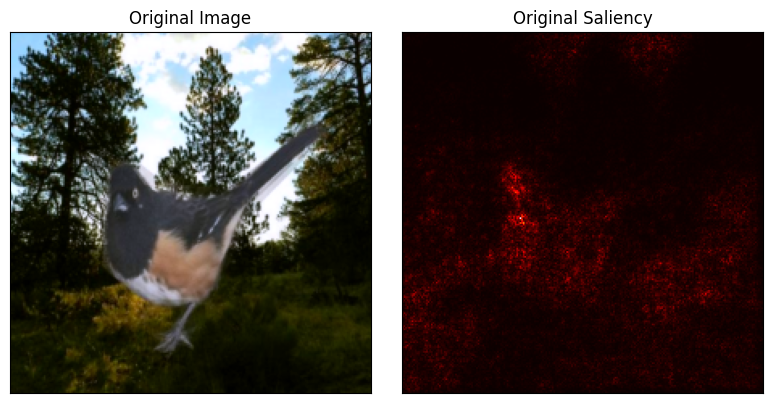

In [75]:
sample_idx = 112
saliency(data[sample_idx][0], data[sample_idx][1], model, mode)